## **Super Resolution Generative Adversarial Network (SRGAN)**

Paper: [Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network](https://arxiv.org/abs/1609.04802)

Helpful Resources:
- [Aladdin Persson's playlist on GANs](https://youtube.com/playlist?list=PLhhyoLH6IjfwIp8bZnzX8QR30TRcHO8Va&si=dcwZjFXOLwdwc6Hp)
- [Balraj Ashwath's SRGAN notebook](https://www.kaggle.com/code/balraj98/single-image-super-resolution-gan-srgan-pytorch)

In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch import einsum
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from torchinfo import summary
from torch import GradScaler, autocast

from einops import rearrange, reduce
from einops.layers.torch import Rearrange

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import os
from PIL import Image
from functools import partial
from tqdm import tqdm
from datetime import datetime
import pytz
import copy
import time
import glob
import gc

print("imports done!")

imports done!


In [3]:
def get_torch_version():
    torch_version = torch.__version__.split("+")[0]
    torch_number = torch_version.split(".")[:2]
    torch_number_float = torch_number[0] + "." + torch_number[1]
    torch_number_float = float(torch_number_float)
    return torch_number_float


def set_seed(seed=42):
    """
    Seeds basic parameters for reproducibility of results
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        # if get_torch_version() <= 1.7:
        #     torch.set_deterministic(True)
        # else:
        #     torch.use_deterministic_algorithms(True)
    print(f"seed {seed} set!")
    

def compute_accuracy(y_pred, y):
    assert len(y_pred)==len(y), "length of y_pred and y must be equal"
    acc = torch.eq(y_pred, y).sum().item()
    acc = acc/len(y_pred)
    return acc


def train_validation_split(train_dataset):
    X_train, X_valid, y_train, y_valid = train_test_split(train_dataset.data, train_dataset.targets, 
                                                          test_size=0.2, random_state=42, shuffle=True, 
                                                          stratify=train_dataset.targets)
    X_train = torch.tensor(X_train, dtype=torch.float64).permute(0, 3, 1, 2)
    X_valid = torch.tensor(X_valid, dtype=torch.float64).permute(0, 3, 1, 2)
    y_train = torch.tensor(y_train, dtype=torch.int64)
    y_valid = torch.tensor(y_valid, dtype=torch.int64)
    return X_train, X_valid, y_train, y_valid
    

def predict(model, img_path, device):
    img = cv2.imread(img_path)
    if img.shape[-1] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
    img2 = img.copy()
    img = torch.tensor(img)
    img = img.permute(1,2,0)
    img = img.unsqueeze(dim=0)
    img = img.to(device)
    model.eval()
    with torch.inference_mode():
        logit = model(img)
    pred_prob = torch.softmax(logit, dim=1)
    pred_label = pred_prob.argmax(dim=1)
    plt.imshow(img2)
    plt.axis("off")
    plt.label(f"Prediction: {classes[pred_label]}\t\tProbability: {round(pred_prob)}")
    plt.show()


def set_scheduler(scheduler, results, scheduler_on):
    """Makes the neccessary updates to the scheduler."""
    if scheduler_on == "valid_acc":
        scheduler.step(results["valid_acc"][-1])
    elif scheduler_on == "valid_loss":
        scheduler.step(results["valid_loss"][-1])
    elif scheduler_on == "train_acc":
        scheduler.step(results["train_acc"][-1])
    elif scheduler_on == "train_loss":
        scheduler.step(results["train_loss"][-1])
    else:
        raise ValueError("Invalid `scheduler_on` choice.")
    return scheduler


def visualize_results(results, plot_name=None):
    """Plot the training and validation loss and accuracy, given the results dictionary"""
    train_loss, train_acc = results["train_loss"], results["train_acc"]
    val_loss, val_acc = results["valid_loss"], results["valid_acc"]
    cls = ["no", "vort", "sphere"]
    x = np.arange(len(train_loss))  # this is the number of epochs
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
    # ax[0,0].set_title("Loss")
    ax[0,0].set_xlabel("Epochs")
    ax[0,0].set_ylabel("Loss")
    ax[0,0].plot(x, train_loss, label="train_loss", color="orange")
    ax[0,0].plot(x, val_loss, label="valid_loss", color="blue")
    ax[0,0].legend()
    # ax[0,1].set_title("Accuracy")
    ax[0,1].set_xlabel("Epochs")
    ax[0,1].set_ylabel("Accuracy")
    ax[0,1].plot(x, train_acc, label="train_acc", color="orange")
    ax[0,1].plot(x, val_acc, label="valid_acc", color="blue")
    ax[0,1].legend()
    # ax[1,0].set_title("Train ROC AUC Plot")
    ax[1,0].set_xlabel("Epochs")
    ax[1,0].set_ylabel("Train ROC AUC Score")
    ax[1,0].plot(x, results["train_roc_auc_0"], label=cls[0])
    ax[1,0].plot(x, results["train_roc_auc_1"], label=cls[1])
    ax[1,0].plot(x, results["train_roc_auc_2"], label=cls[2])
    ax[1,0].legend()
    # ax[1,1].set_title("Valid ROC AUC Plot")
    ax[1,1].set_xlabel("Epochs")
    ax[1,1].set_ylabel("Valid ROC AUC Score")
    ax[1,1].plot(x, results["valid_roc_auc_0"], label=cls[0])
    ax[1,1].plot(x, results["valid_roc_auc_1"], label=cls[1])
    ax[1,1].plot(x, results["valid_roc_auc_2"], label=cls[2])
    ax[1,1].legend()
    if plot_name is not None:
        plt.savefig(plot_name)
    plt.show()
    

def train_step(model, loss_fn, optimizer, dataloader, device, scaler=None):
    model.train()
    train_loss = 0
    train_acc = 0
    all_labels = []
    all_preds = []
    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        if scaler is not None:           # do automatic mixed precision training
            with autocast(device):       # mixed precision forward pass
                logit = model(X)
                pred_prob = torch.softmax(logit, dim=1)
                pred_label = pred_prob.argmax(dim=1)
                # note: first put logit and then y in the loss_fn
                # otherwise, if you put y first and then logit, then it will raise an error
                loss = loss_fn(logit, y)
            scaler.scale(loss).backward()      # mixed precision backward pass
            scaler.step(optimizer)             # updating optimizer
            scaler.update()                    # updating weights
        else:                     # don't do any mixed precision training
            logit = model(X)
            pred_prob = torch.softmax(logit, dim=1)
            pred_label = pred_prob.argmax(dim=1)
            loss = loss_fn(logit, y)
            loss.backward()
            optimizer.step()
        all_labels.extend(y.detach().cpu().numpy())
        all_preds.extend(pred_prob.detach().cpu().numpy())
        train_loss += loss.item()
        acc = compute_accuracy(pred_label, y)
        train_acc += acc
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    return train_loss, train_acc, all_labels, all_preds
        

def valid_step(model, loss_fn, dataloader, device):
    model.eval()
    valid_loss = 0
    valid_acc = 0
    all_labels = []
    all_preds = []
    with torch.inference_mode():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            logit = model(X)
            pred_prob = torch.softmax(logit, dim=1)
            pred_label = pred_prob.argmax(dim=1)
            # note: first put logit and then y in the loss_fn
            # otherwise, if you put y first and then logit, then it will raise an error
            loss = loss_fn(logit, y)
            valid_loss += loss.item()
            acc = compute_accuracy(pred_label, y)
            valid_acc += acc
            all_labels.extend(y.detach().cpu().numpy())
            all_preds.extend(pred_prob.detach().cpu().numpy())
    valid_loss = valid_loss / len(dataloader)
    valid_acc = valid_acc / len(dataloader)
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    return valid_loss, valid_acc, all_labels, all_preds


def training_fn1(model, loss_fn, optimizer, train_dataloader, valid_dataloader, device, 
                 epochs, scheduler=None, scheduler_on="val_acc", verbose=False, scaler=None,
                 save_best_model=False, path=None, model_name=None, optimizer_name=None, 
                 scheduler_name=None):
    """
    Does model training and validation for one fold in a k-fold cross validation setting.
    """
    results = {
        "train_loss": [],
        "train_acc": [],
        "valid_loss": [],
        "valid_acc": [],
        "train_roc_auc_0": [],
        "valid_roc_auc_0": [],
        "train_roc_auc_1": [],
        "valid_roc_auc_1": [],
        "train_roc_auc_2": [],
        "valid_roc_auc_2": [],
    }
    best_valid_roc_auc = 0.0
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc, train_labels, train_preds = train_step(model, loss_fn, optimizer, 
                                                                      train_dataloader, device, scaler)
        valid_loss, valid_acc, valid_labels, valid_preds = valid_step(model, loss_fn, valid_dataloader, 
                                                                      device)
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["valid_loss"].append(valid_loss)
        results["valid_acc"].append(valid_acc)
        bin_train_labels = label_binarize(train_labels, classes=[0,1,2])
        bin_valid_labels = label_binarize(valid_labels, classes=[0,1,2])
        mean_train_roc_auc = np.mean([results["train_roc_auc_0"], results["train_roc_auc_1"],
                                          results["train_roc_auc_2"]])
        mean_valid_roc_auc = np.mean([results["valid_roc_auc_0"], results["valid_roc_auc_1"],
                                          results["valid_roc_auc_2"]])
        for i in range(3):
            try:
                train_roc_auc = roc_auc_score(bin_train_labels[:, i], train_preds[:, i])
                valid_roc_auc = roc_auc_score(bin_valid_labels[:, i], valid_preds[:, i])
                results[f"train_roc_auc_{i}"].append(train_roc_auc)
                results[f"valid_roc_auc_{i}"].append(valid_roc_auc)
            except ValueError:
                print(f"Warning: AUC computation failed for class {i}")
        if verbose:
            print(
                    f"Epoch: {epoch+1} | Train_loss: {train_loss:.5f} | "
                    f"Train_acc: {train_acc:.5f} | Val_loss: {valid_loss:.5f} | "
                    f"Val_acc: {valid_acc:.5f} | Train_roc_auc: {mean_train_roc_auc:.5f} | "
                    f"Val_roc_auc: {mean_valid_roc_auc:.5f}"
                )
        if scheduler is not None:
            scheduler = set_scheduler(scheduler, results, scheduler_on)
            if mean_valid_roc_auc > best_valid_roc_auc:
                best_valid_roc_auc = mean_valid_roc_auc
                plot_name = path + "/" + model_name[:-3] + "_" + optimizer_name[:-3] + "_" + scheduler_name[:-3] + ".pdf"
                save_model_info(path, device, model, model_name, optimizer, optimizer_name, 
                    scheduler, scheduler_name)
        else:
            if mean_valid_roc_auc > best_valid_roc_auc:
                best_valid_roc_auc = mean_valid_roc_auc
                plot_name = path + "/" + model_name[:-3] + "_" + optimizer_name[:-3] + ".pdf"
                save_model_info(path, device, model, model_name, optimizer, optimizer_name) 
    visualize_results(results, plot_name)


def training_fn2(model, loss_fn, optimizer, train_dataset, device, epochs, 
                 scheduler=None, scheduler_on="val_acc", verbose=False, n_splits=5, scaler=None):
    """
    Does the training and validation for all the folds in a k-fold cross validation setting.
    """
    kf = StratifiedKFold(n_splits=n_splits, random_state=42, shuffle=True)
    MODELS = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(X=train_dataset.data, y=train_dataset.targets)):
        train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, 
                                      sampler=SubsetRandomSampler(train_idx))
        valid_dataloader = DataLoader(dataset=train_dataset, batch_size=64, 
                                      sampler=SubsetRandomSampler(val_idx))
        results = training_fn1(model, loss_fn, optimizer, train_dataloader, valid_dataloader, device, 
                                epochs, scheduler=scheduler, scheduler_on=scheduler_on, verbose=verbose)
        train_loss = np.mean(results["train_loss"])
        valid_loss = np.mean(results["valid_loss"])
        train_acc = np.mean(results["train_acc"])
        valid_acc = np.mean(results["valid_acc"])
        print(
                f"Fold: {fold+1} | Train_loss: {train_loss:.5f} | "
                f"Train_acc: {train_acc:.5f} | Val_loss: {valid_loss:.5f} | "
                f"Val_acc: {valid_acc:.5f}"
            )
        visualize_results(results)
        MODELS.append(model)
    return MODELS


def training_function(model, loss_fn, optimizer, train_dataset, device, epochs, scheduler=None, 
                      scheduler_on="val_acc", verbose=False, validation_strategy="train test split",
                      n_splits=5, scaler=None):
    """
    validation_strategy: choose one of the following: 
        - "train test split"
        - "k-fold cross validation"
    """
    if validation_strategy == "train test split":
        X_train, X_valid, y_train, y_valid = train_validation_split(train_dataset)
        train_dataset = CustomDataset(features=X_train, targets=y_train)
        valid_dataset = CustomDataset(features=X_valid, targets=y_valid)
        train_dataloader = DataLoader(dataset=train_dataset, batch_size=CONFIG["batchsize"], shuffle=True)
        valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=CONFIG["batchsize"], shuffle=False)
        training_fn1(model, loss_fn, optimizer, train_dataloader, valid_dataloader, device, epochs, 
                     scheduler=scheduler, scheduler_on=scheduler_on, verbose=verbose)
    elif validation_strategy == "k-fold cross validation":
        training_fn2(model, loss_fn, optimizer, train_dataset, device, epochs, scheduler=scheduler, 
                     scheduler_on=scheduler_on, verbose=verbose, n_splits=n_splits)
    else:
        raise ValueError("Invalid validation strategy.\nChoose either \"train test split\" \
        or \"k-fold cross validation\"")
    

def save_model_info(path: str, device, model, model_name, optimizer, optimizer_name, 
                    scheduler=None, scheduler_name=""):
    model.to(device)
    torch.save(model.state_dict(), os.path.join(path,model_name))
    torch.save(optimizer.state_dict(), os.path.join(path,optimizer_name))
    if scheduler is not None:
        torch.save(scheduler.state_dict(), os.path.join(path,scheduler_name))    
    print("Model info saved!")
    
    
def load_model_info(PATH, device, model, model_name, optimizer, optimizer_name, 
                    scheduler=None, scheduler_name=""):
    model.load_state_dict(torch.load(os.path.join(path,model_name)))
    model.to(device)
    optimizer.load_state_dict(torch.load(os.path.join(path,optimizer_name)))
    if scheduler is not None:
        scheduler.load_state_dict(torch.load(os.path.join(path,scheduler_name)))
    print("Model info loaded!")
    
    
def get_current_time():
    """Returns the current time in Toronto."""
    now = datetime.now(pytz.timezone('Canada/Eastern'))
    current_time = now.strftime("%d_%m_%Y__%H_%M_%S")
    return current_time


print("Utility functions created!")

Utility functions created!


In [4]:
get_torch_version()

2.5

In [5]:
set_seed(42)

seed 42 set!


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### **Data Processing**

In [7]:
# path = "../input/div2k-high-resolution-images/"
path = "../input/"
train_path = path + "DIV2K_train_HR/DIV2K_train_HR/"
valid_path = path+"DIV2K_valid_HR/DIV2K_valid_HR/"
print("No. of images in the training dataset:\t\t", len(os.listdir(train_path)))
print("No. of images in the validation dataset:\t", len(os.listdir(valid_path)))

No. of images in the training dataset:		 800
No. of images in the validation dataset:	 100


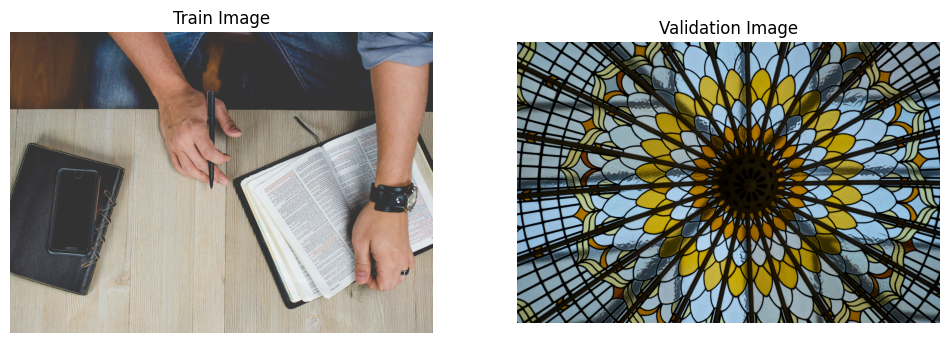

In [8]:
def fn():
    train_img_name = random.choice(os.listdir(train_path))
    valid_img_name = random.choice(os.listdir(valid_path))
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,12))
    ax[0].imshow(plt.imread(train_path+train_img_name))
    ax[0].axis("off")
    ax[0].set_title("Train Image")
    ax[1].imshow(plt.imread(valid_path+valid_img_name))
    ax[1].axis("off")
    ax[1].set_title("Validation Image")
    plt.show()

fn()

In [9]:
# use this code to free up gpu memory
gc.collect()
torch.cuda.empty_cache()
print("freed up some memory!")

freed up some memory!


<figure>
  <div style="text-align: center;">
  <img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-19_at_11.13.45_AM_zsF2pa7.png" width="600" alt="SRGAN"/>
  </div>
  <figcaption>
  <p style="text-align:center;">
  <b>SRGAN architecture.</b>
  </p>
  <p style="text-align:center;">
  Source: <a href="https://paperswithcode.com/method/srgan">Papers With Code</a> (original by <a href="https://arxiv.org/abs/1609.04802">Ledig et al. 2017</a>)
  </p>
  </figcaption>
</figure>

### **Generator**

In [10]:
# Define a single Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, channels=64):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.prelu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        # Skip connection adds the input to the block's output
        return out + residual

# Define an Upsample Block using sub-pixel convolution (PixelShuffle)
class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, scale_factor=2):
        super(UpsampleBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * (scale_factor ** 2), kernel_size=3, stride=1, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(scale_factor)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        return self.prelu(x)

# Define the Generator Network
class Generator(nn.Module):
    def __init__(self, num_residual_blocks=16, upscale_factor=4):
        super(Generator, self).__init__()
        # Initial convolution to extract low-level features
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=4)
        self.prelu1 = nn.PReLU()
        
        # Series of residual blocks
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(64) for _ in range(num_residual_blocks)]
        )
        
        # Post-residual block convolution to fuse features
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Upsampling layers: If upscale_factor is 4, we need two upsample blocks (each scaling by 2)
        upsample_blocks = []
        num_upsample = int(upscale_factor // 2)
        for _ in range(num_upsample):
            upsample_blocks.append(UpsampleBlock(64, scale_factor=2))
        self.upsample = nn.Sequential(*upsample_blocks)
        
        # Final output layer to generate the high-resolution image
        self.conv3 = nn.Conv2d(64, 3, kernel_size=9, stride=1, padding=4)
        
    def forward(self, x):
        # Initial feature extraction
        out1 = self.prelu1(self.conv1(x))
        # Deep feature extraction through residual blocks
        out = self.residual_blocks(out1)
        # Fuse features with an additional convolution and skip connection
        out = self.bn2(self.conv2(out))
        out = out1 + out
        # Upsample to the desired resolution
        out = self.upsample(out)
        # Produce final high-resolution image
        out = self.conv3(out)
        return out

# Example usage:
if __name__ == "__main__":
    # Create a dummy low-resolution image tensor: batch_size=1, channels=3, height=24, width=24
    lr_image = torch.randn(1, 3, 24, 24)
    generator = Generator(num_residual_blocks=16, upscale_factor=4)
    # Output high-resolution image: should be 4 times larger in height and width (i.e., 96x96)
    sr_image = generator(lr_image)
    print("Input shape:", lr_image.shape)
    print("Output shape:", sr_image.shape)


Input shape: torch.Size([1, 3, 24, 24])
Output shape: torch.Size([1, 3, 96, 96])


In [11]:
# use this code to free up gpu memory
gc.collect()
torch.cuda.empty_cache()
print("freed up some memory!")

freed up some memory!


### **Discriminator**

In [12]:
class Discriminator(nn.Module):
    def __init__(self, input_size=96):
        super(Discriminator, self).__init__()
        # Convolutional layers that progressively extract features and reduce spatial dimensions.
        self.net = nn.Sequential(
            # Layer 1: Convolution without batch normalization
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 2: Downsample by stride=2
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 3: Increase channel count
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 4: Downsample
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 5: Further increasing channels
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 6: Downsample
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 7: Increase to 512 channels
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 8: Final downsampling layer
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        # After 4 downsampling layers (stride=2 each), a 96x96 image becomes 6x6.
        # Flatten and use fully connected layers for classification.
        self.classifier = nn.Sequential(
            nn.Linear(512 * 6 * 6, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
            nn.Sigmoid()  # Output a probability (real vs. fake)
        )
        
    def forward(self, x):
        out = self.net(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

# Example usage:
if __name__ == "__main__":
    # Create a dummy high-resolution image tensor: batch_size=1, channels=3, height=96, width=96
    hr_image = torch.randn(1, 3, 96, 96)
    discriminator = Discriminator(input_size=96)
    output = discriminator(hr_image)
    print("Input shape:", hr_image.shape)
    print("Output shape:", output.shape)  # Expected shape: [1, 1] indicating the probability of being real


Input shape: torch.Size([1, 3, 96, 96])
Output shape: torch.Size([1, 1])


In [13]:
# use this code to free up gpu memory
gc.collect()
torch.cuda.empty_cache()
print("freed up some memory!")

freed up some memory!


### **Loss Functions**

In [14]:
# VGG Feature Extractor for Perceptual Loss
class VGGFeatureExtractor(nn.Module):
    def __init__(self, feature_layer=35, use_bn=False, use_input_norm=True, 
                 device='cuda' if torch.cuda.is_available() else "cpu"):
        super(VGGFeatureExtractor, self).__init__()
        # Load pre-trained VGG19 (with or without batch normalization)
        if use_bn:
            vgg_model = models.vgg19_bn(pretrained=True).to(device)
        else:
            vgg_model = models.vgg19(pretrained=True).to(device)
        self.use_input_norm = use_input_norm
        self.device = device
        # Register mean and std buffers for normalization (ImageNet stats)
        self.register_buffer('mean', torch.Tensor([0.485, 0.456, 0.406]).view(1,3,1,1).to(device))
        self.register_buffer('std', torch.Tensor([0.229, 0.224, 0.225]).view(1,3,1,1).to(device))
        # Extract features up to the specified layer
        self.features = nn.Sequential(*list(vgg_model.features.children())[:feature_layer])
        # Freeze the VGG parameters
        for param in self.features.parameters():
            param.requires_grad = False

    def forward(self, x):
        # Normalize input if required
        x = x.to(device)
        if self.use_input_norm:
            x = (x - self.mean) / self.std
        return self.features(x)

# Perceptual Loss using VGG Feature Extractor
class PerceptualLoss(nn.Module):
    def __init__(self, feature_layer=35, use_bn=False, weight=1.0, 
                 device='cuda' if torch.cuda.is_available() else "cpu"):
        super(PerceptualLoss, self).__init__()
        self.vgg = VGGFeatureExtractor(feature_layer, use_bn, use_input_norm=True, device=device)
        self.criterion = nn.MSELoss()
        self.weight = weight

    def forward(self, sr, hr):
        sr_features = self.vgg(sr)
        hr_features = self.vgg(hr)
        loss = self.criterion(sr_features, hr_features) * self.weight
        return loss

# Pixel-wise Loss (either MSE or L1)
class PixelLoss(nn.Module):
    def __init__(self, mode='MSE', weight=1.0):
        super(PixelLoss, self).__init__()
        if mode == 'MSE':
            self.criterion = nn.MSELoss()
        elif mode == 'L1':
            self.criterion = nn.L1Loss()
        else:
            raise ValueError("Unsupported mode: choose 'MSE' or 'L1'")
        self.weight = weight

    def forward(self, sr, hr):
        loss = self.criterion(sr, hr) * self.weight
        return loss

# Adversarial Loss using Binary Cross Entropy
class AdversarialLoss(nn.Module):
    def __init__(self, weight=1e-3):
        super(AdversarialLoss, self).__init__()
        self.criterion = nn.BCEWithLogitsLoss()
        self.weight = weight

    def forward(self, pred, target):
        loss = self.criterion(pred, target) * self.weight
        return loss

# Example usage for testing the loss functions:
if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # Create dummy tensors for super-resolved (sr) and high-res (hr) images
    sr = torch.randn(1, 3, 96, 96).to(device)
    hr = torch.randn(1, 3, 96, 96).to(device)
    
    # Perceptual Loss
    perceptual_loss = PerceptualLoss(feature_layer=35, use_bn=False, weight=1.0, device=device)
    p_loss = perceptual_loss(sr, hr)
    print("Perceptual loss:", p_loss.item())

    # Pixel-wise Loss (MSE)
    pixel_loss = PixelLoss(mode='MSE', weight=1.0)
    pix_loss = pixel_loss(sr, hr)
    print("Pixel loss (MSE):", pix_loss.item())

    # Adversarial Loss example (dummy prediction and target)
    adversarial_loss = AdversarialLoss(weight=1e-3)
    # Dummy prediction from the discriminator for a generated image
    pred = torch.randn(1, 1).to(device)
    # Target label: 1 for a real image
    target = torch.ones(1, 1).to(device)
    adv_loss = adversarial_loss(pred, target)
    print("Adversarial loss:", adv_loss.item())


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 231MB/s] 


Perceptual loss: 6.741415023803711
Pixel loss (MSE): 2.014131546020508
Adversarial loss: 0.0007090025465004146


In [15]:
# use this code to free up gpu memory
gc.collect()
torch.cuda.empty_cache()
print("freed up some memory!")

freed up some memory!


### **Training Strategy**

In [19]:
# =======================
# 1. DIV2K Dataset Loader
# =======================
class DIV2KDataset(Dataset):
    """
    Custom dataset for DIV2K high-resolution images.
    It assumes images are stored in a directory (hr_dir) in a common image format.
    The dataset applies two transforms:
      - transform_hr: crops and converts the HR image to tensor.
      - transform_lr: downsamples the original PIL image to create the corresponding LR image.
    """
    def __init__(self, hr_dir, crop_size=96, upscale_factor=4):
        super(DIV2KDataset, self).__init__()
        self.hr_image_paths = glob.glob(os.path.join(hr_dir, '*.png'))
        if len(self.hr_image_paths) == 0:
            self.hr_image_paths = glob.glob(os.path.join(hr_dir, '*.jpg'))
        self.crop_size = crop_size
        self.upscale_factor = upscale_factor

        # Transform for HR images: random crop and convert to tensor.
        self.hr_transform = transforms.Compose([
            transforms.RandomCrop(crop_size),
            transforms.ToTensor()
        ])
        # Transform for LR images: random crop the same region and then downscale.
        self.lr_transform = transforms.Compose([
            transforms.RandomCrop(crop_size),
            transforms.Resize(crop_size // upscale_factor, interpolation=Image.BICUBIC),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.hr_image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.hr_image_paths[idx]).convert("RGB")
        # To ensure corresponding crops, we apply the same random crop parameters:
        i, j, h, w = transforms.RandomCrop.get_params(img, output_size=(self.crop_size, self.crop_size))
        hr_image = transforms.functional.crop(img, i, j, h, w)
        lr_image = hr_image.resize((self.crop_size // self.upscale_factor, self.crop_size // self.upscale_factor), Image.BICUBIC)
        # Finally, convert both to tensors.
        hr_tensor = transforms.ToTensor()(hr_image)
        lr_tensor = transforms.ToTensor()(lr_image)
        return lr_tensor, hr_tensor

# =======================
# 2. Training Strategy
# =======================
if __name__ == "__main__":
    # --- Settings ---
    device = "cuda" if torch.cuda.is_available() else "cpu"
    hr_dir = train_path   # Set this to the DIV2K high-resolution images directory.
    crop_size = 96
    upscale_factor = 4
    batch_size = 64
    num_pretrain_epochs = 10     # Number of epochs for pre-training the generator.
    num_adv_epochs = 50          # Number of epochs for adversarial training.
    learning_rate = 3e-4
    weight_decay = 1e-5
    scaler_G = GradScaler(device)
    scaler_D = GradScaler(device)

    # --- Initialize Dataset and DataLoader ---
    dataset = DIV2KDataset(hr_dir=hr_dir, crop_size=crop_size, upscale_factor=upscale_factor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    # --- Import previously defined components ---
    # Assume the following classes are defined (or imported from another module):
    #   Generator, Discriminator, PixelLoss, PerceptualLoss, AdversarialLoss
    # For example:
    # from srgan_models import Generator, Discriminator, PixelLoss, PerceptualLoss, AdversarialLoss

    # Instantiate models
    generator = Generator(num_residual_blocks=16, upscale_factor=upscale_factor).to(device)
    discriminator = Discriminator(input_size=crop_size).to(device)

    # Instantiate loss functions
    pixel_loss = PixelLoss(mode='MSE', weight=1.0).to(device)
    perceptual_loss = PerceptualLoss(feature_layer=35, use_bn=False, weight=1.0, device=device).to(device)
    adversarial_loss = AdversarialLoss(weight=1e-3).to(device)

    # Optimizers for pre-training and adversarial training
    optimizer_G = optim.AdamW(generator.parameters(), lr=learning_rate, weight_decay=weight_decay)
    optimizer_D = optim.AdamW(discriminator.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # ---------------------------
    # Stage 1: Pre-train Generator
    # ---------------------------
    print("Starting pre-training of the generator using pixel loss...")
    generator.train()
    for epoch in tqdm(range(num_pretrain_epochs)):
        epoch_loss = 0.0
        for lr_imgs, hr_imgs in dataloader:
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)
            optimizer_G.zero_grad()
            with autocast(device):
                sr_imgs = generator(lr_imgs)
                loss = pixel_loss(sr_imgs, hr_imgs)
            scaler_G.scale(loss).backward()
            scaler_G.step(optimizer_G)
            scaler_G.update()

            epoch_loss += loss.item()

        print(f"Pretrain Epoch [{epoch+1}/{num_pretrain_epochs}], Loss: {epoch_loss/len(dataloader):.4f}")

    # ---------------------------
    # Stage 2: Adversarial Training
    # ---------------------------
    print("Starting adversarial training...")
    for epoch in range(num_adv_epochs):
        g_loss_epoch = 0.0
        d_loss_epoch = 0.0
        for lr_imgs, hr_imgs in dataloader:
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)

            # ---------------------------------
            # Update Discriminator: maximize log(D(HR)) + log(1-D(SR))
            # ---------------------------------
            discriminator.train()
            optimizer_D.zero_grad()
            with autocast(device):
                # Real images label: 1, Fake images label: 0
                valid = torch.ones((lr_imgs.size(0), 1), device=device)
                fake = torch.zeros((lr_imgs.size(0), 1), device=device)
    
                # Loss for real HR images
                real_pred = discriminator(hr_imgs)
                d_loss_real = nn.BCELoss()(real_pred, valid)
    
                # Generate super-resolved images
                sr_imgs = generator(lr_imgs)
                fake_pred = discriminator(sr_imgs.detach())
                d_loss_fake = nn.BCELoss()(fake_pred, fake)
    
                d_loss = (d_loss_real + d_loss_fake) / 2
            scaler_D.scale(d_loss).backward()
            scaler_D.step(optimizer_D)
            scaler_D.update()

            # ---------------------------------
            # Update Generator: minimize perceptual + pixel-wise + adversarial losses
            # ---------------------------------
            optimizer_G.zero_grad()
            with autocast(device):
                # Generate images for generator update
                sr_imgs = generator(lr_imgs)
    
                # Re-compute adversarial loss with the updated discriminator
                pred_fake = discriminator(sr_imgs)
                loss_adv = adversarial_loss(pred_fake, valid)
    
                loss_pixel = pixel_loss(sr_imgs, hr_imgs)
                loss_perceptual = perceptual_loss(sr_imgs, hr_imgs)
                # Total generator loss: weights can be tuned as needed
                g_loss = loss_pixel + loss_perceptual + loss_adv
            scaler_G.scale(g_loss).backward()
            scaler_G.step(optimizer_G)
            scaler_G.update()

            g_loss_epoch += g_loss.item()
            d_loss_epoch += d_loss.item()

        print(f"Adv Epoch [{epoch+1}/{num_adv_epochs}]  Generator Loss: {g_loss_epoch/len(dataloader):.4f}, "
              f"Discriminator Loss: {d_loss_epoch/len(dataloader):.4f}")

    # Save the final models (optional)
    torch.save(generator.state_dict(), "srgan_generator.pth")
    torch.save(discriminator.state_dict(), "srgan_discriminator.pth")
    torch.save(optimizer_G.state_dict(), "optimizer_generator.pth")
    torch.save(optimizer_D.state_dict(), "optimizer_discriminator.pth")
    print("Training completed and models and optimizers are saved.")


Starting pre-training of the generator using pixel loss...


 10%|█         | 1/10 [00:27<04:09, 27.76s/it]

Pretrain Epoch [1/10], Loss: 0.0624


 20%|██        | 2/10 [00:55<03:40, 27.51s/it]

Pretrain Epoch [2/10], Loss: 0.0187


 30%|███       | 3/10 [01:22<03:12, 27.50s/it]

Pretrain Epoch [3/10], Loss: 0.0143


 40%|████      | 4/10 [01:49<02:44, 27.37s/it]

Pretrain Epoch [4/10], Loss: 0.0117


 50%|█████     | 5/10 [02:17<02:17, 27.44s/it]

Pretrain Epoch [5/10], Loss: 0.0105


 60%|██████    | 6/10 [02:44<01:48, 27.23s/it]

Pretrain Epoch [6/10], Loss: 0.0085


 70%|███████   | 7/10 [03:10<01:21, 27.10s/it]

Pretrain Epoch [7/10], Loss: 0.0082


 80%|████████  | 8/10 [03:38<00:54, 27.23s/it]

Pretrain Epoch [8/10], Loss: 0.0077


 90%|█████████ | 9/10 [04:06<00:27, 27.37s/it]

Pretrain Epoch [9/10], Loss: 0.0083


100%|██████████| 10/10 [04:33<00:00, 27.36s/it]

Pretrain Epoch [10/10], Loss: 0.0074
Starting adversarial training...


RuntimeError: torch.nn.functional.binary_cross_entropy and torch.nn.BCELoss are unsafe to autocast.
Many models use a sigmoid layer right before the binary cross entropy layer.
In this case, combine the two layers using torch.nn.functional.binary_cross_entropy_with_logits
or torch.nn.BCEWithLogitsLoss.  binary_cross_entropy_with_logits and BCEWithLogits are
safe to autocast.

In [18]:
# use this code to free up gpu memory
gc.collect()
torch.cuda.empty_cache()
print("freed up some memory!")

freed up some memory!
